# Process Bursts

This notebook computes the burst drift for all bursts using the method show in `BurstDrift.ipynb`

In [1]:
#!/usr/bin/python3

from __future__ import division
import math
import os
import sys
import time
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
from math import log10
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import pi as nombrepi
from scipy import signal, ndimage
from tqdm import tqdm
from matplotlib import colors as mcolors
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd
import corrfns

bursts = pd.read_csv('bursts.csv')

# Gaussian 2d Fit Stuff
# Source: https://gist.github.com/andrewgiessel/6122739
# Source: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m
def gaussian(height, center_x, center_y, width_x, width_y, rotation):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)

    rotation = np.deg2rad(rotation)
    center_x_old = center_x
    center_x = center_x * np.cos(rotation) - center_y * np.sin(rotation)
    center_y = center_x_old * np.sin(rotation) + center_y * np.cos(rotation)

    def rotgauss(x,y):
        xp = x * np.cos(rotation) - y * np.sin(rotation)
        yp = x * np.sin(rotation) + y * np.cos(rotation)
        g = height*np.exp( -(((center_x-xp)/width_x)**2  +((center_y-yp)/width_y)**2)/2.  )
        return g
    return rotgauss

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y, 2.0

def twoD_Gaussian(point, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = point
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = (np.sin(2*theta))/(2*sigma_x**2) - (np.sin(2*theta))/(2*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - a*((x-xo)**2) - b*(x-xo)*(y-yo) - c*((y-yo)**2))
    return g.ravel()

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = scipy.optimize.leastsq(errorfunction, params)
    return p, success

def fitgaussiannlsq(data, sigma=0):
    # use curve-fit (non-linear leastsq)
    x = range(0, 1023); y = range(0, 1023)
    x, y = np.meshgrid(x, y)
    params = moments(data)#+ (0.,)
    sigma = np.zeros(len(data.ravel())) + sigma
    popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x, y), data.ravel(), p0=params, sigma=sigma, absolute_sigma=True)
    return popt, pcov

  0%|          | 0/28 [00:00<?, ?it/s]

processing 02_puppi_57747_C0531+33_0558_1183.dm559.72.calibP.RM.DD.ASCII
Data loaded
finding auto-correlation...
autocorr_sigma 4.174782079087327
finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]


solution nlsq: [ 81.49221057 512.49442555 512.4783396  177.67605797  44.62740083
   8.05717689]
parameter 1sigma: [0.03742787 0.02595439 0.0800134  0.08178352 0.02048607 0.00017409]
pcov diag: [1.40084532e-03 6.73630346e-04 6.40214376e-03 6.68854395e-03
 4.19678877e-04 3.03082058e-08]
pcov:
[[ 0.001  0.    -0.    -0.002 -0.     0.   ]
 [ 0.     0.001 -0.001 -0.     0.    -0.   ]
 [-0.    -0.001  0.006  0.     0.    -0.   ]
 [-0.002 -0.     0.     0.007  0.    -0.   ]
 [-0.     0.     0.     0.     0.    -0.   ]
 [ 0.    -0.    -0.    -0.    -0.     0.   ]]
reduced chisq: 3.8184129607306407
solver angle: 8.057176893895857 pos angle: 8.057176893895857
drift: -740.5785704696756
drift error: 0.6523165260063905
saved figures/burst_2_figure.png


  7%|▋         | 2/28 [00:58<12:45, 29.44s/it]

processing 03_puppi_57747_C0531+33_0558_1202.dm559.72.calibP.RM.DD.ASCII
Data loaded
finding auto-correlation...
autocorr_sigma 4.086719372997774
finding fit...
solution nlsq: [184.110978   512.4955582  512.35654137 170.31670446  19.22062972
   1.62478075]
parameter 1sigma: [5.70116864e-02 6.58744098e-03 5.26558409e-02 5.28221858e-02
 5.94991090e-03 5.00520838e-05]
pcov diag: [3.25033239e-03 4.33943786e-05 2.77263758e-03 2.79018332e-03
 3.54014397e-05 2.50521109e-09]
pcov:
[[ 0.003  0.    -0.    -0.002 -0.     0.   ]
 [ 0.     0.    -0.    -0.    -0.    -0.   ]
 [-0.    -0.     0.003  0.     0.    -0.   ]
 [-0.002 -0.     0.     0.003  0.    -0.   ]
 [-0.    -0.     0.     0.     0.    -0.   ]
 [ 0.    -0.    -0.    -0.    -0.     0.   ]]
reduced chisq: 4.049444686415699
solver angle: 1.6247807532384837 pos angle: 1.6247807532384837
drift: -2823.7705198758676
drift error: 2.623174493614193
saved figures/burst_3_figure.png


100%|██████████| 28/28 [01:32<00:00,  3.31s/it]


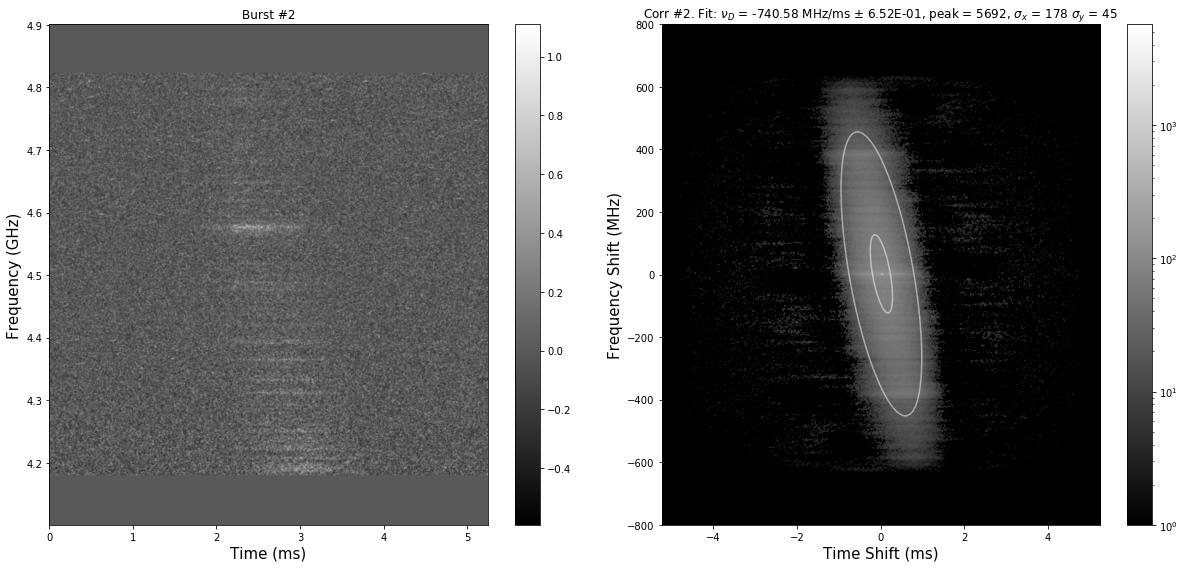

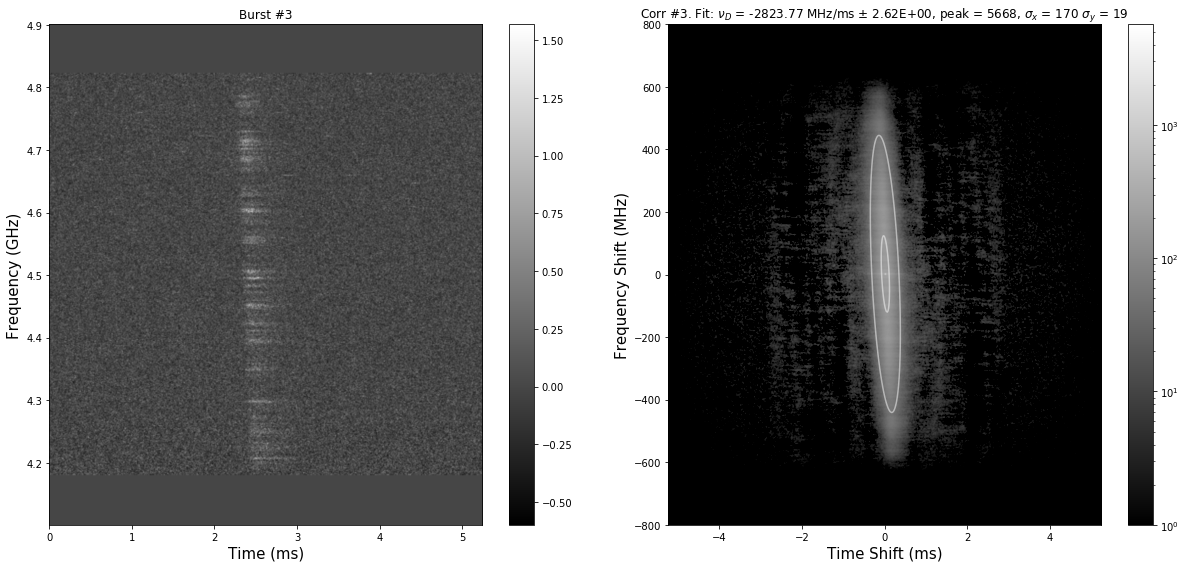

In [2]:
folder = 'data'
outfolder = 'figures'
sigmax_error = []
sigmay_error = []
angle_error  = []
drift_errors = []
drifts       = []
autocorrs    = []
auto_sigmas  = []
red_chisqs   = []
corredges = [(10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 250),
             (10, 300),
             (10, 250),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300)]

# Stuff for figure 4
burst2data = {}
burst3data = {}

for burst, filename, edge in tqdm( zip(range(1, len(bursts['filename'])+1), bursts['filename'], bursts['edge']), total=len(bursts['filename']) ):
    
    if 'gajjar' in filename:
        continue
    if burst not in [2, 3]:  continue
    print('processing {}'.format(filename))
    #junk, nchan, nbin, I, Q, U, V = np.loadtxt('{}/{}'.format(folder, filename), delimiter=' ', unpack=True)
    #Q, U, V = None, None, None
    
    junk, nchan, nbin, I = [], [], [], []
    with open('{}/{}'.format(folder, filename)) as infile:
        for line in infile:
            junki, nchani, nbini, Ii, _, _, _ = line.split(' ')
            junk.append(junki)
            nchan.append(nchani)
            nbin.append(nbini)
            I.append(Ii)
    junk  = np.array(junk, dtype=float)
    nchan = np.array(nchan, dtype=float)
    nbin  = np.array(nbin, dtype=float)
    I     = np.array(I, dtype=float)
    
    n = len(junk)
    edge = int(edge)
    print("Data loaded")
    
    binmax = int(nbin[n-1])+1
    frequencymax = (int(nchan[n-1])+1)
    intensity = np.zeros((frequencymax, binmax))

    X = np.zeros(binmax)
    Y = np.zeros(frequencymax)

    # what are these?
    tmin = 500 
    tmax = 1500

    #### 1. remove noise
    intensitynoise1 = np.zeros(tmin-1)
    intensitynoise2 = np.zeros(binmax-tmax)
    for i in tqdm(range(frequencymax-50,51,-1), desc='noise removal', disable=True):

        Y[i-1] = 4.15 + (i-1) * 1.5625 # ?

        for j in range(1,tmin) :

            intensitynoise1[j-1] = (I[j-1 + binmax*(frequencymax-i)])/(tmin-1)


        for j in range(tmax+1,binmax+1) :

            intensitynoise2[j-1-tmax] = (I[j-1 + binmax*(frequencymax-i)])/(binmax-tmax)

        a = sum(intensitynoise1)
        b = sum(intensitynoise2)

        for j in range(1,binmax+1) :
            X[j-1] = j-1
            intensity[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)] - (a+b)/2

    #### 2. find autocorrelation 
    burstwindow = intensity[:,edge:edge+frequencymax]
    print("finding auto-correlation...")
    #corr = signal.correlate2d(burstwindow, burstwindow, mode='full')
    #print(corr.shape)
    corr = corrfns.auto_corr2D_viafft(burstwindow)
   
    #### 2.5 Autocorr noise
    autocorr_sigma = np.std( corr[:, corredges[burst-1][0]:corredges[burst-1][1]] )
    print('autocorr_sigma', autocorr_sigma)
    auto_sigmas.append(autocorr_sigma)

    #### 3. Fit Gaussian to autocorrelation
    print("finding fit...")
    popt, pcov = fitgaussiannlsq(corr, sigma=autocorr_sigma)
    perr = np.sqrt(np.diag(pcov))
    x = range(0, 1023); y = range(0, 1023)
    x, y = np.meshgrid(x, y)
    fitmap2 = twoD_Gaussian((x, y), *popt).reshape(1023, 1023)
    print('solution nlsq:', popt)
    print('parameter 1sigma:', perr)
    print('pcov diag:', np.diag(pcov))
    with np.printoptions(precision=3, suppress=True):
        print('pcov:')
        print(pcov)
    
    # calculate reduced chisquared
    residuals = corr - fitmap2
    chisq = np.sum((residuals / autocorr_sigma) ** 2)
    red_chisq = chisq / (corr.shape[0]*corr.shape[1] - len(popt)) # this is chisq/(M-N)
    red_chisqs.append(red_chisq)
    print('reduced chisq:', red_chisq)
    
    ### 3.5 Compute drift and error
    theta = popt[-1] if popt[3] > popt[4] else popt[-1] - np.pi/2
    print('solver angle:', popt[-1], 'pos angle:', theta)
    slope = np.tan(theta)
    drift = 1.5625/0.01024 * slope # MHz/ms
    drift_error = (1.5625/0.01024) * (perr[-1] * (1/np.cos(theta))**2)
    sigmax_error.append(perr[3])
    sigmay_error.append(perr[4])
    angle_error.append(perr[5])
    drift_errors.append(drift_error)  
    drifts.append(drift)       
    print('drift:', drift)
    print('drift error:', drift_error)
    
    #### 4. Plot
    cmap = plt.get_cmap('gray')
    cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!

    plt.figure(figsize=(17,8))
    plt.subplot(121)
    plt.title("Burst #{}".format(burst))
    burstextents = [0, 
           10.24e-6 * burstwindow.shape[-1] * 1e3, 
           4100.78125 * 1e-3, 
           (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]
    plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)
    plt.xlabel("Time (ms)", size=15)
    plt.ylabel("Frequency (GHz)", size=15)
    plt.colorbar()

    plt.subplot(122)
    plt.title("Corr #{}. Fit: $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2E}, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, drift, drift_error, np.max(corr), popt[3], popt[4]))

    corrextents = [-10.24e-6 * (corr.shape[1]/2) * 1e3, 
           10.24e-6 * (corr.shape[1]/2) * 1e3 , 
           (4100.78125 -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2, 
           ((4100.78125 + 1.5625*burstwindow.shape[-2]) -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2]
    #plt.imshow(corr, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower") # linear scale
    #plt.clim(0, np.max(corr)/10)
    plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corrextents)
    plt.xlabel("Time Shift (ms)", size=15)
    plt.ylabel("Frequency Shift (MHz)", size=15)
    plt.colorbar()
    
    plt.contour(fitmap2, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

    if burst == 2: 
        burst2data['corr'] = corr
        burst2data['burstwindow'] = burstwindow
        burst2data['fitmap'] = fitmap2
        burst2data['popt']  = popt
    if burst == 3:
        burst3data['corr'] = corr
        burst3data['burstwindow'] = burstwindow
        burst3data['fitmap'] = fitmap2
        burst3data['popt']  = popt
    
    plt.tight_layout()
    # plt.savefig('{}/burst_{}_figure.png'.format(outfolder, burst))
    print('saved {}/burst_{}_figure.png'.format(outfolder, burst))

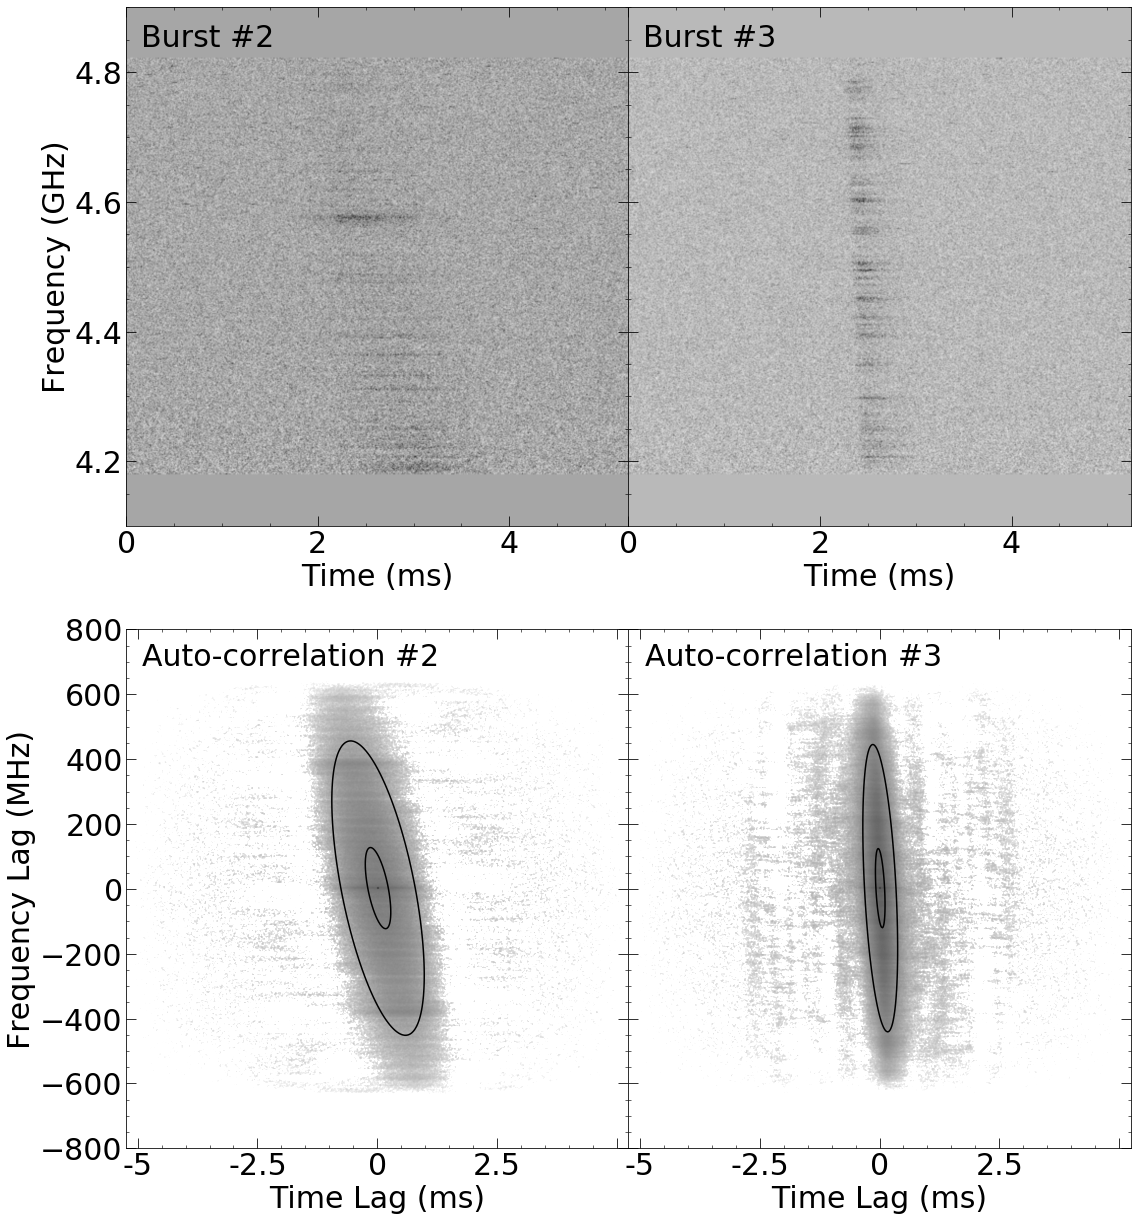

In [64]:
### Figure 4
cmap = plt.get_cmap('gray_r')
cmap.set_bad(color = 'w', alpha = 1.) # potentially hides important errors in the data!

burstextents = [0, 
       10.24e-6 * burstwindow.shape[-1] * 1e3, 
       4100.78125 * 1e-3, 
       (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]
corrextents = [-10.24e-6 * (corr.shape[1]/2) * 1e3, 
       10.24e-6 * (corr.shape[1]/2) * 1e3 , 
       (4100.78125 -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2, 
       ((4100.78125 + 1.5625*burstwindow.shape[-2]) -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2]

# plt.figure(figsize=(18,18))
plt.figure(figsize=(18,21))
# plt.title("Burst #{}".format(burst))
labelsize = 30
for burstdata, ploti, burstnum in zip([burst2data, burst3data], [1,2], [2,3]):
    plt.subplot(2, 2, ploti)
    ## Formatting
    plt.annotate('Burst #{}'.format(burstnum), (0.15, 4.84), size=labelsize)
    plt.xlabel("Time (ms)", size=labelsize)
    if ploti == 1: plt.ylabel('Frequency (GHz)', size=labelsize)
    labelleft = True if ploti == 1 else False
    plt.tick_params(labelsize=labelsize, direction='in', length=10, top=True, right=True, labelleft=labelleft)
    plt.tick_params(which='minor', direction='in', top=True, right=True, length=3)
    plt.minorticks_on()
    ## Burst spectrrum
    plt.imshow(burstdata['burstwindow'], cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)

    plt.subplot(2, 2, ploti+2)
    ## Formatting
    plt.annotate('Auto-correlation #{}'.format(burstnum), (-4.9, 690), size=labelsize)
    plt.xlabel('Time Lag (ms)', size=labelsize)
    if ploti+2 != 4: plt.ylabel('Frequency Lag (MHz)', size=labelsize)
    labelleft = True if ploti+2 != 4 else False
    plt.tick_params(labelsize=labelsize, direction='in', length=10, top=True, right=True, labelleft=labelleft)
    plt.tick_params(which='minor', direction='in', top=True, right=True, length=3)
    
    plt.minorticks_on()
    ## Corr spectrrum
    plt.imshow(burstdata['corr'], cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corrextents)
    plt.contour(burstdata['fitmap'], [burstdata['popt'][0]/4, burstdata['popt'][0]*0.9], colors='k', alpha=1, origin='lower', extent=corrextents)
    plt.xticks([-5, -2.5, 0, 2.5, 5], [str(x) for x in [-5, -2.5, 0, 2.5, '']])

# plt.subplots_adjust(wspace=-1.9)
plt.subplots_adjust(wspace=0)
# plt.tight_layout()
for f in ['png', 'pdf', 'eps']: plt.savefig('paper_figures/burst2and3.{}'.format(f))

[111.48222725470062,
 6.749708479459105,
 7.793460963473907,
 3.246709336058745,
 3.2250095103092544,
 3.9144321659667836,
 5.526043142433374,
 9.157308395680246,
 3.218699593900001,
 3.290370671709115,
 3.4115435044866764,
 4.053156380451369,
 31.95620389349233,
 9.048346578597009,
 4.599277250304015,
 73.59034980033088]

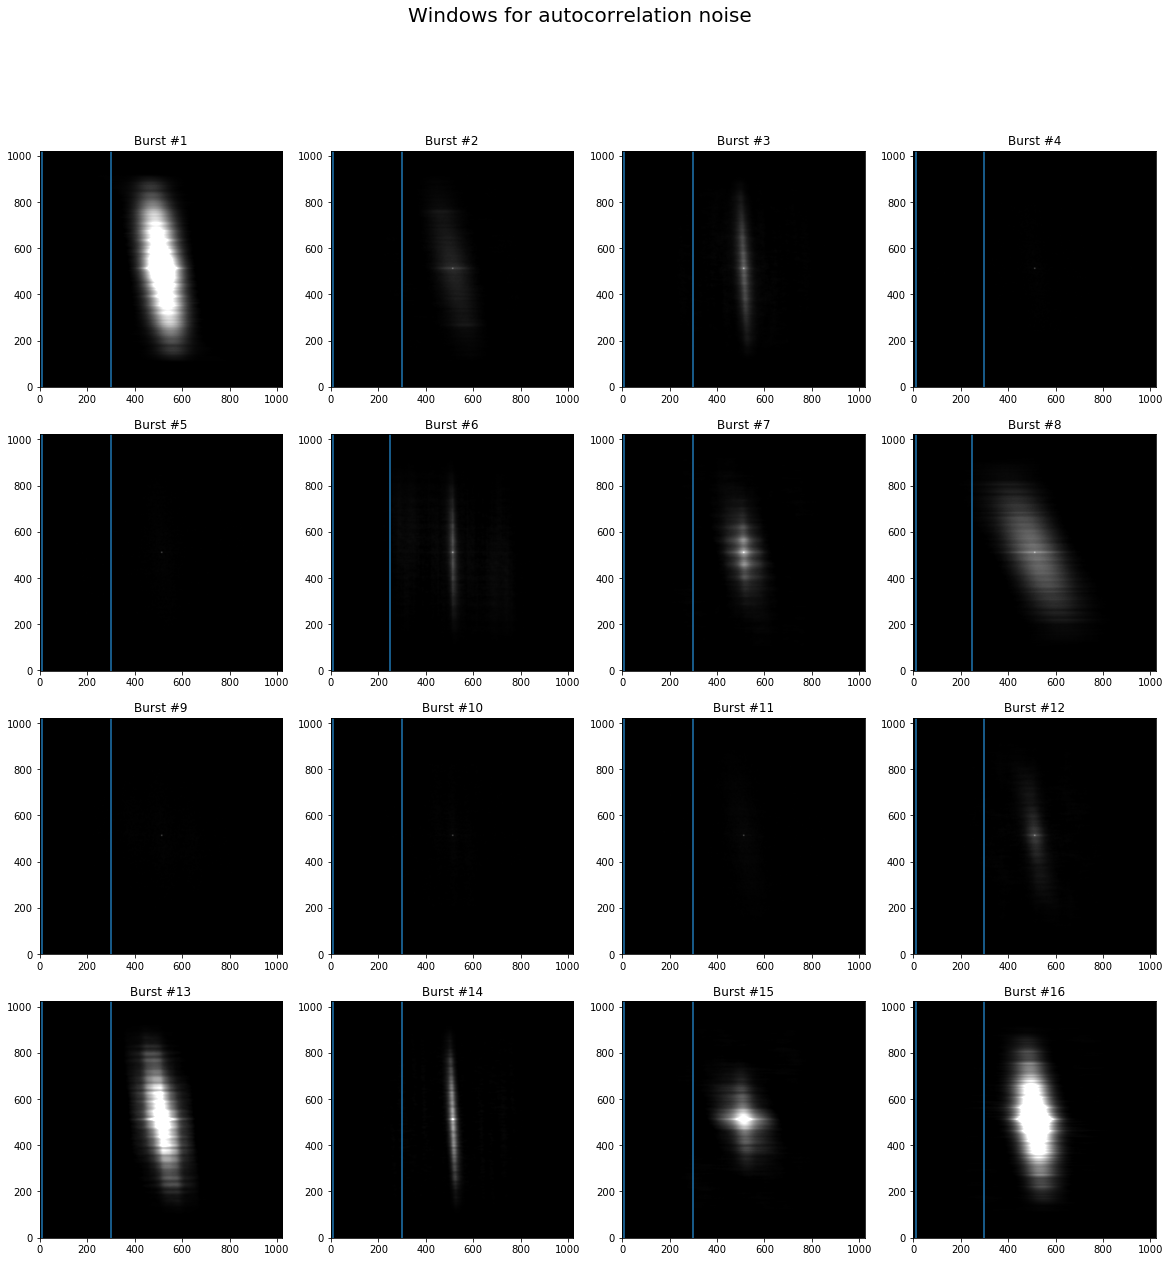

In [9]:
## Autocorrelation Noise Windows
titles = ["Burst #{}".format(x) for x in list(range(1, 17))]
corredges = [(10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 250),
             (10, 300),
             (10, 250),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300)]
sigmas = []

plt.figure(figsize=(20, 20))
plt.suptitle('Windows for autocorrelation noise', size=20)
for title, ac, corredge in zip(titles, autocorrs, corredges):
    plt.subplot(4, 4, titles.index(title)+1)
    plt.title(title)
    plt.imshow(ac, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray')
    plt.axvline(x=corredge[0]); plt.axvline(x=corredge[1])
    plt.clim(0, np.max(ac)/10)

    sigmas.append(np.std(ac[corredge[0]:corredge[1]]))

# slice ex.:
# plt.imshow(autocorrs[0][:,corredges[0][0]:corredges[0][1]], aspect='auto', interpolation='bicubic', origin='lower', cmap='gray')
# plt.clim(0, np.max(autocorrs[0])/10)
    
sigmas

In [5]:
# Export parameter errors
bursts = bursts.head(16)
bursts['sigmax_error'] = sigmax_error 
bursts['sigmay_error'] = sigmay_error 
bursts['angle_error']  = angle_error  
bursts['red_chisq']    = red_chisqs
bursts['drift_errors_raw'] = drift_errors  
bursts['drifts_raw'] = drifts  
# bursts['sigmax_raw'] = sigmax 
# bursts['sigmay_raw'] = drifts 

params = bursts[['name', 'sigmax_error', 'sigmay_error', 'angle_error', 'red_chisq', 'drift_errors_raw', 'drifts_raw']]
params.to_csv('params_temp.csv')
params

,name,sigmax_error,sigmay_error,angle_error,red_chisq,drift_errors_raw,drifts_raw
0,M1,0.011140,0.003007,0.000026,9.733683,0.190767,-1039.359422
1,M2,0.081784,0.020486,0.000174,3.818413,0.652317,-740.578570
2,M3,0.052822,0.005950,0.000050,4.049445,2.623174,-2823.770520
3,M4,1.780140,0.292807,0.002672,3.318850,21.768613,-1104.400675
4,M5,0.258022,1.153948,0.002306,3.360715,67.749909,-2111.820516
5,M6,0.065385,0.005173,0.000047,6.719788,11.249634,-6051.049456
6,M7,0.019954,0.007547,0.000121,6.302707,0.845772,-1019.972935
7,M8,0.019619,0.007370,0.000071,6.146570,0.064490,-340.369797
8,M9,1.038778,0.697559,0.013465,3.361416,5.297999,-191.720255
9,M10,0.887502,0.318304,0.003938,3.375381,18.569260,-834.397589


In [ ]:
cmap = plt.get_cmap('PiYG')
cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!

plt.figure(figsize=(17,8))
plt.subplot(121)
plt.title("Burst #{}".format(burst))
burstextents = [0, 
       10.24e-6 * burstwindow.shape[-1] * 1e3, 
       4100.78125 * 1e-3, 
       (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]
plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)
plt.xlabel("Time (ms)", size=15)
plt.ylabel("Frequency (GHz)", size=15)
plt.clim(0, 0.3)
print(np.median(burstwindow))
plt.colorbar()

plt.subplot(122)
plt.title("Corr #{}. Fit: $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2E}, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, drift, drift_error, np.max(corr), popt[3], popt[4]))
# plt.imshow(corr, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower") # linear scale
# plt.clim(0, np.max(corr)/2)
corrextents = [-10.24e-6 * (corr.shape[1]/2) * 1e3, 
       10.24e-6 * (corr.shape[1]/2) * 1e3 , 
       (4100.78125 -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2, 
       ((4100.78125 + 1.5625*burstwindow.shape[-2]) -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2]
plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corrextents)
plt.xlabel("Time Shift (ms)", size=15)
plt.ylabel("Frequency Shift (MHz)", size=15)
plt.colorbar()

plt.contour(fitmap2, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,10))
cmap = plt.get_cmap('gray')
cmap.set_bad(color = 'k', alpha = 1.)
plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1))
print(np.max(corr), np.min(corr))
# linear cmap
# plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower")
# plt.clim(0, np.max(corr)/2)

plt.colorbar()


In [ ]:
cmap = "gray"
x = range(0, 1023); y = range(0, 1023)
x, y = np.meshgrid(x, y)
# amplitude, xo, yo, sigma_x, sigma_y, theta
testmap = twoD_Gaussian((x, y), *[1.8e+03, 5.11e+02, 5.11e+02, 1.74e+02, 4.7e+01, 1.425]).reshape(1023, 1023)
popt = [1.8e+03, 5.11e+02, 5.11e+02, 1.74e+02, 4.7e+01, 1.425]

plt.figure(figsize=(10,8))
plt.title("Correlation #{}. Fit: $\\theta$ = {:.2f} rad, peak = {:.0f}, $\sigma_x$ = {} $\sigma_y$ = {}".format(burst, popt[-1], 1000, 1, 1))
print(burstwindow.shape)
burstextents = [0, 
           10.24e-6 * burstwindow.shape[-1] * 1e3, 
           4100.78125 * 1e-3, 
           (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]

plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)
plt.xlabel("Time (ms)", size=20)
plt.ylabel("Frequency (GHz)", size=20)
plt.colorbar()


In [ ]:
x = range(0, 1023); y = range(0, 1023)
x, y = np.meshgrid(x, y)
popt = [1,2,3,4,5,6]; burst = 1
fitmap2 = twoD_Gaussian((x, y), *popt).reshape(1023, 1023)
drift = 1; perr = 1
cmap = "gray"
plt.figure(figsize=(10,10))
plt.title("Corr #{}. Fit: $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2f}, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(1,1,1,1,1,1))
# plt.title("TESTCorr #{}. Fit: $\\theta$ = {:.2f}rad, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, popt[-1], np.max(corr), popt[3], popt[4]))
# corrextents = [-10.24e-6 * corr.shape[1] * 1e3 / 2, 
#            10.24e-6 * corr.shape[1] * 1e3 / 2, 
#            (4100.78125 -  (4100.78125 + 1.5625*corr.shape[0]/2) ) * 1e-3, 
#            (4100.78125 +  (4100.78125 + 1.5625*corr.shape[0]/2) ) * 1e-3]
plt.imshow(fitmap2, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1))#, extent=corrextents)
plt.colorbar()
# plt.contour(fitmap2, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

In [ ]:
corrextents = [-10.24e-6 * (corr.shape[1]/2) * 1e3, 
           10.24e-6 * (corr.shape[1]/2) * 1e3 , 
           (4100.78125 -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2, 
           ((4100.78125 + 1.5625*burstwindow.shape[-2]) -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2]
corrextents